# Chicago Taxi Trips Analysis

Dataset from Chicago Taxi Trips in 2021 is used in this analysis.

In [90]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import bokeh
import geopy as gp
import pygeohash as gh
from IPython.display import display 

from functions import cleanData

%matplotlib inline
plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format

In [91]:
# import Taxi Trip data from CSV into DataFrame
cache = {}
def cached_date_parser(s):
    if s in cache:
        return cache[s]
    dt = pd.to_datetime(s)
    cache[s] = dt
    return dt

df_csv =  pd.read_csv("Taxi_Trips_-_2021.csv", parse_dates=[2,3] , infer_datetime_format=True, date_parser=cached_date_parser)
# cleanData
df =  cleanData(df_csv,True)


Total rows dropped to remove null =  1590 (% =  0.07401635063081483 )
Total rows dropped to remove large numbers =  4410 (% =  0.20529063288169394 )
Total rows dropped to remove zeroes =  344601 (% =  16.041577637565673 )
Total rows dropped to remove large Miles per Minute =  5939 (% =  0.27646736251346493 )


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1791634 entries, 0 to 2148172
Data columns (total 23 columns):
Trip ID                       object
Taxi ID                       object
Trip Start Timestamp          datetime64[ns]
Trip End Timestamp            datetime64[ns]
Trip Seconds                  float64
Trip Miles                    float64
Pickup Census Tract           float64
Dropoff Census Tract          float64
Pickup Community Area         float64
Dropoff Community Area        float64
Fare                          float64
Tips                          float64
Tolls                         float64
Extras                        float64
Trip Total                    float64
Payment Type                  object
Company                       object
Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Pickup Centroid Location      object
Dropoff Centroid Latitude     float64
Dropoff Centroid Longitude    float64
Dropoff Centroid  Location    object
dtype

#### Summary


In [93]:
plt.rcParams['font.size'] = '11'

In [94]:
print("Total Trips: ",len(df['Trip ID'].unique()))
print("Total Taxis: ",len(df['Taxi ID'].unique()))

Total Trips:  1791634
Total Taxis:  1638


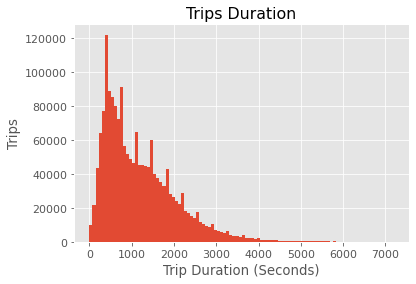

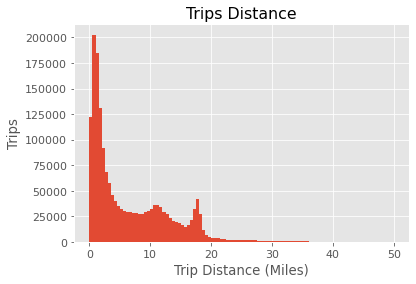

In [95]:
# distribution of trip duration
fig, ax = plt.subplots()

ax.set_xlabel('Trip Duration (Seconds)')
ax.set_ylabel('Trips')

ax.set_title('Trips Duration')

ax.hist(df['Trip Seconds'],bins = 100,range = [0,7200])
plt.show()

# distribution of trip distance
fig, ax = plt.subplots()

ax.set_xlabel('Trip Distance (Miles)')
ax.set_ylabel('Trips')

ax.set_title('Trips Distance')

ax.hist(df['Trip Miles'],bins = 100,range = [0,50])
plt.show()

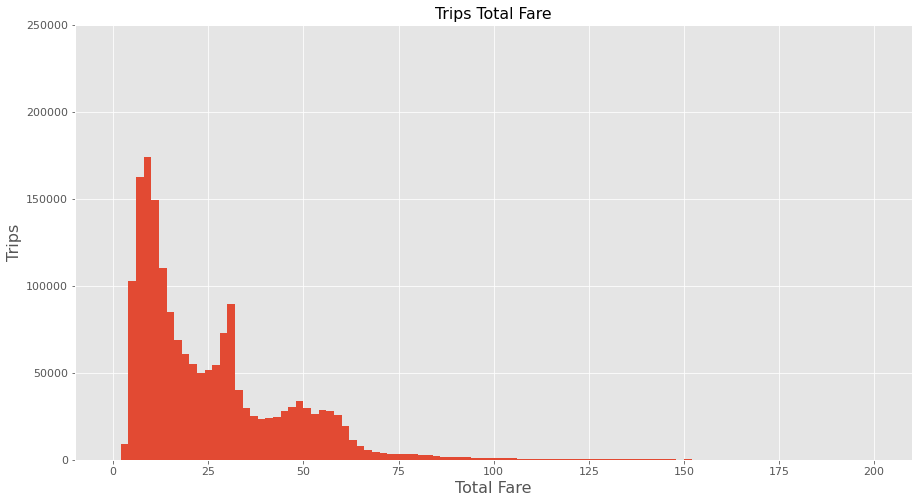

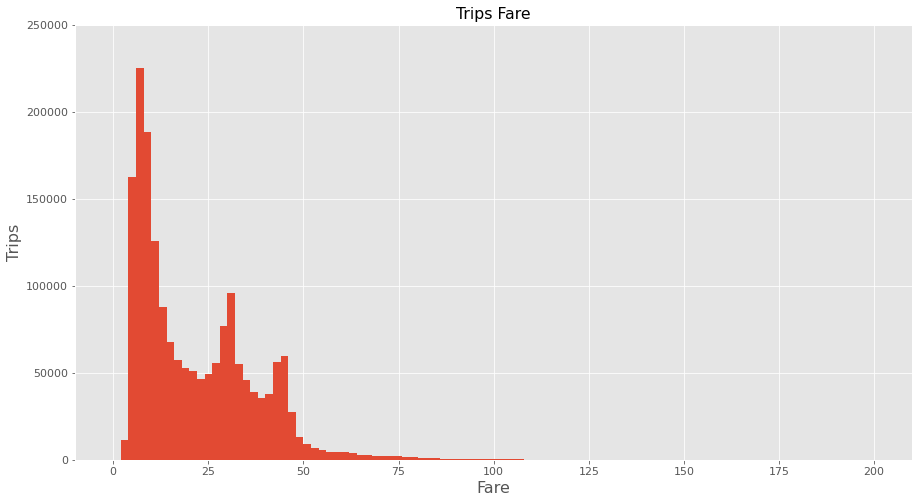

In [96]:
ymin = 0
ymax = 250000
# distribution of total fares
fig, ax = plt.subplots()

ax.set_xlabel('Total Fare', fontsize = '16')
ax.set_ylabel('Trips', fontsize = '16')

ax.set_title('Trips Total Fare')
fig.set_size_inches(15,8)

ax.set_ylim([ymin,ymax])
ax.hist(df['Trip Total'],bins = 100,range = [0,200], stacked=True)
plt.show()

# distribution of fare
fig, ax = plt.subplots()

ax.set_xlabel('Fare', fontsize = '16')
ax.set_ylabel('Trips', fontsize = '16')

ax.set_title('Trips Fare')
fig.set_size_inches(15,8)
ax.set_ylim([ymin,ymax])
ax.hist(df['Fare'],bins = 100,range = [0,200], stacked=True)
plt.show()

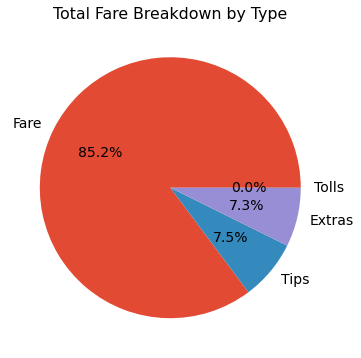

,Dollars
Fare,"38,710,167.68"
Tips,"3,385,191.15"
Extras,"3,317,281.10"
Tolls,"6,754.12"


In [97]:
# breakdown of charges
df_charges = df[['Fare','Tips','Tolls','Extras']].sum().sort_values(ascending = False)

fig, ax = plt.subplots()
ax.set_title('Total Fare Breakdown by Type')

data_charges_piechart = df_charges
ax.pie(data_charges_piechart , labels = data_charges_piechart.index, autopct='%1.1f%%',  textprops={'fontsize': 14})
fig.set_size_inches(6,6)

plt.show()

display(pd.DataFrame(df_charges, columns = ['Dollars']))

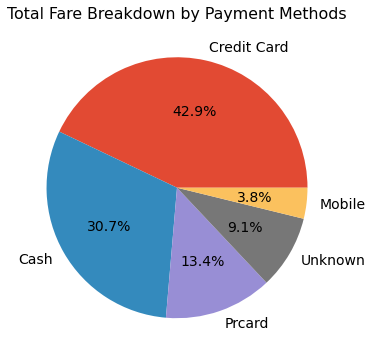

,Trip Total
Payment Type,
Credit Card,"19,563,446.73"
Cash,"14,001,231.70"
Prcard,"6,098,679.45"
Unknown,"4,168,978.63"
Mobile,"1,744,345.50"
Dispute,"35,631.30"
No Charge,"19,497.12"


In [98]:
# breakdown of payment method
fig, ax = plt.subplots()
df_payment = df.groupby(['Payment Type']).sum()['Trip Total']
df_payment = df_payment.sort_values(ascending = False)
ax.set_title('Total Fare Breakdown by Payment Methods')

data_piechart = df_payment.drop(labels= ['No Charge','Dispute'])
ax.pie(data_piechart , labels = data_piechart .index,autopct='%1.1f%%', textprops={'fontsize': 14})
fig.set_size_inches(6,6)
plt.show()

display(pd.DataFrame(df_payment))

In [99]:
## add hour and day of week columns
df['Trip Start Hour'] = df['Trip Start Timestamp'].dt.hour
df['Trip Date'] = df['Trip Start Timestamp'].dt.date
df['Trip Month'] = df['Trip Start Timestamp'].dt.month
df['Trip Day of Week'] = df['Trip Start Timestamp'].dt.dayofweek

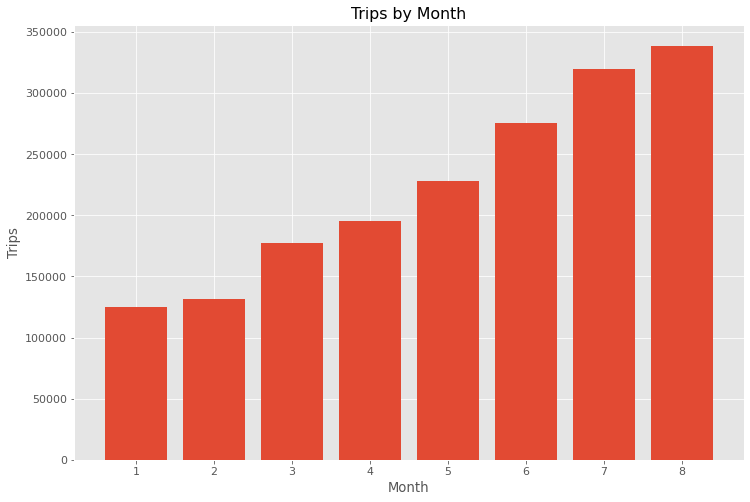

In [100]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.set_xlabel('Month')
ax.set_ylabel('Trips')
ax.set_title('Trips by Month')
ax.set_xticks( range(1,9))

ax.bar( range(1,9),df[df['Trip Month'] < 9].groupby(['Trip Month']).size())

plt.show()

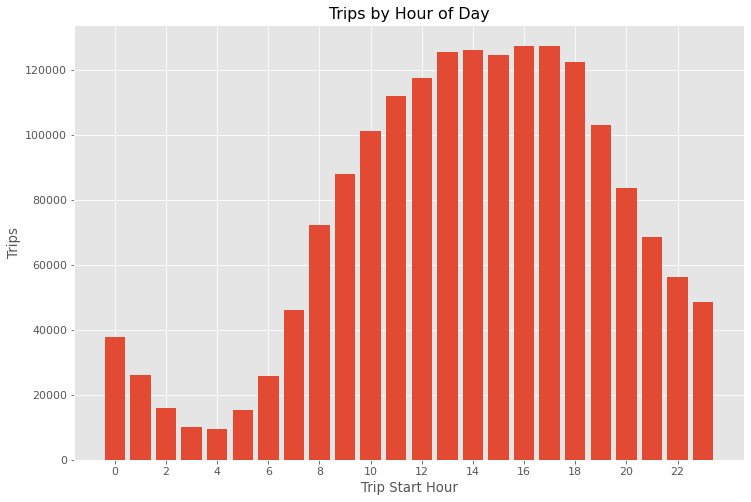

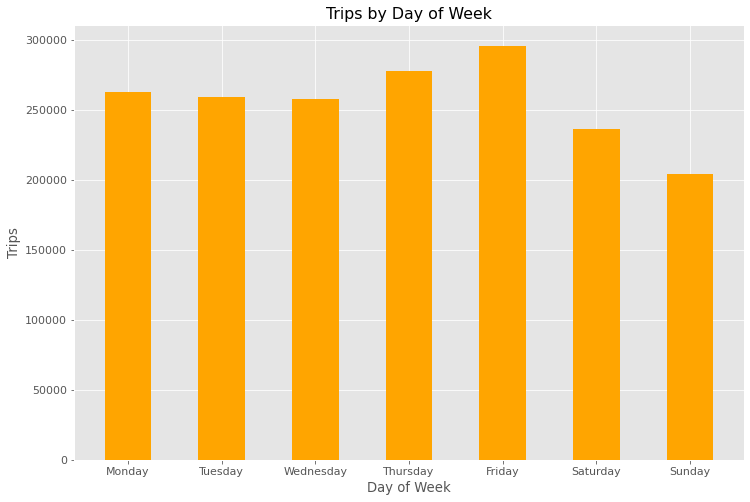

In [101]:
# hour and day analysis
def plotHourAndDayTrends(df_input):
    # distribution of trips within a day; by hour
    fig, ax = plt.subplots()
    fig.set_size_inches(12,8)

    ax.set_xlabel('Trip Start Hour')
    ax.set_ylabel('Trips')
    ax.set_title('Trips by Hour of Day')
    ax.set_xticks( range(0,24,2))

    ax.bar( range(0,24),df_input.groupby(['Trip Start Hour']).size())

    plt.show()

    
    # distribution of trips based on day of the week    
    dayofweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

    fig, ax = plt.subplots()
    fig.set_size_inches(12,8)

    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Trips')
    ax.set_title('Trips by Day of Week')
    
    data_dayofweek = df_input.groupby(['Trip Day of Week']).size()

    ax.bar(range(7), data_dayofweek, width = 0.5, color = 'orange')
    ax.set_xticks(range(7))
    ax.set_xticklabels(dayofweek)
    plt.show()
    
plotHourAndDayTrends(df)

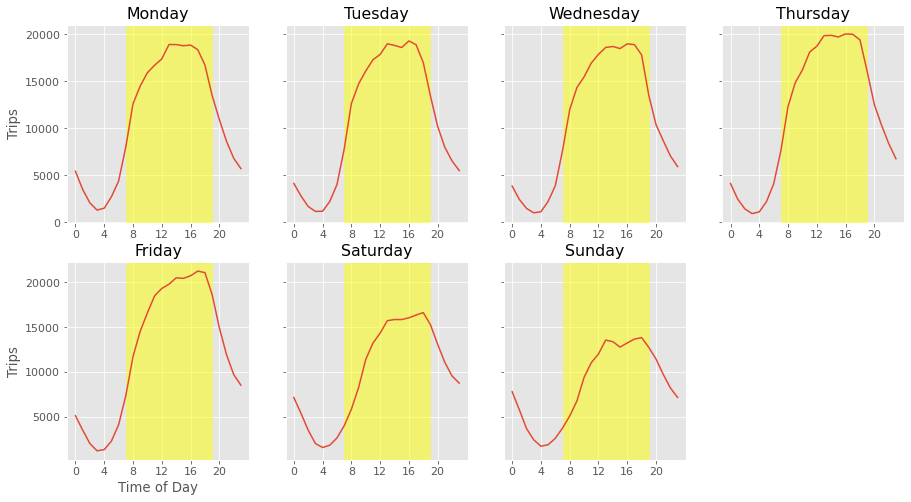

In [102]:
## trip by time of day
plot_data = df.groupby(['Trip Day of Week','Trip Start Hour']).size()
fig, axs = plt.subplots(2,4,sharey='row', figsize=(15,8))
axs[-1, -1].axis('off')
dayofweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

axs[0,0].set_ylabel('Trips')
axs[1,0].set_ylabel('Trips')
axs[1,0].set_xlabel('Time of Day')
day = 0
for r in range (2):
    for c in range (4):
        if(day < 7): 
            axs[r,c].set_title(dayofweek[day])
            axs[r,c].plot(plot_data[day])
            axs[r,c].set_xticks( range(0,24,4))
            axs[r,c].axvspan(7, 19,color='yellow', alpha=0.5 )
            day = day + 1
plt.show()


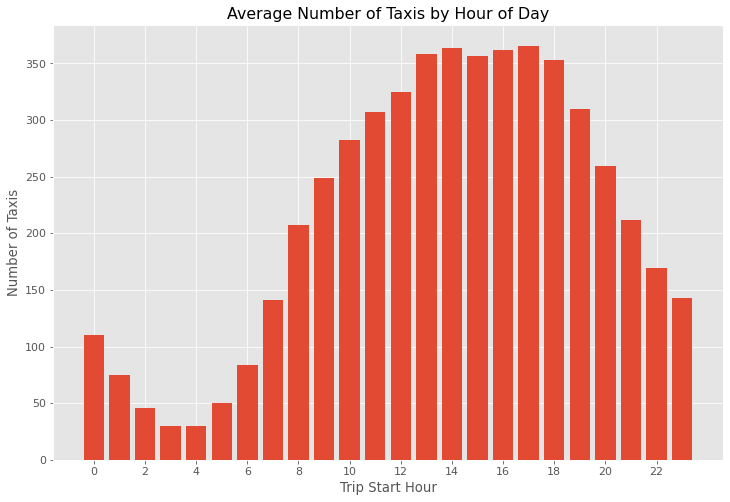

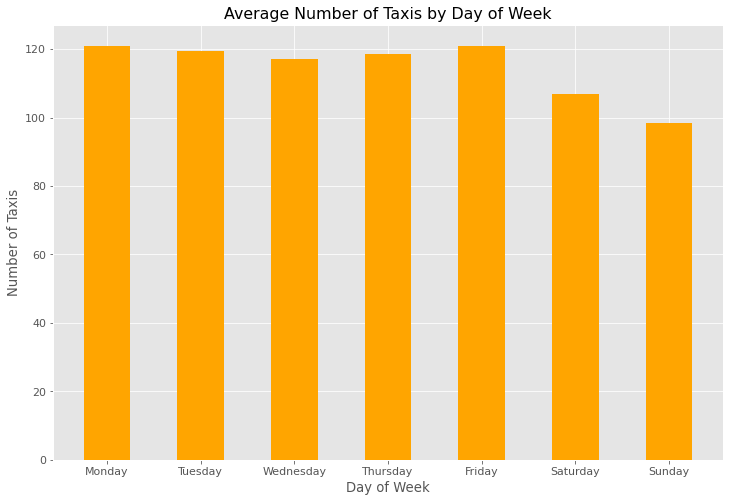

In [131]:
total_days_in_dataset = len(df.groupby(['Trip Date']))

# distribution of trips within a day; by hour
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.set_xlabel('Trip Start Hour')
ax.set_ylabel('Number of Taxis')
ax.set_title('Average Number of Taxis by Hour of Day')
ax.set_xticks( range(0,24,2))

ax.bar( range(0,24),df.groupby(['Taxi ID','Trip Start Hour','Trip Date']).size().groupby(['Trip Start Hour']).size()/(total_days_in_dataset))
plt.show()


# # distribution of trips based on day of the week    
dayofweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Taxis')
ax.set_title('Average Number of Taxis by Day of Week')

data_dayofweek = df.groupby(['Taxi ID','Trip Day of Week','Trip Date']).size().groupby(['Trip Day of Week']).size()/(total_days_in_dataset)
ax.bar(range(7), data_dayofweek, width = 0.5, color = 'orange')
ax.set_xticks(range(7))
ax.set_xticklabels(dayofweek)
plt.show()

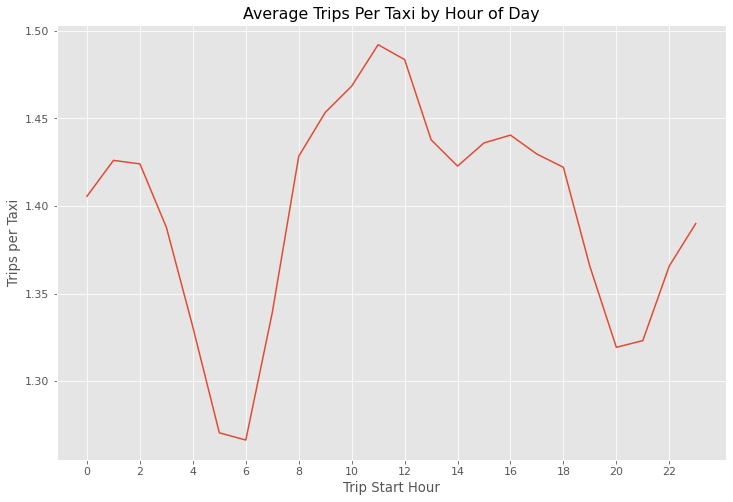

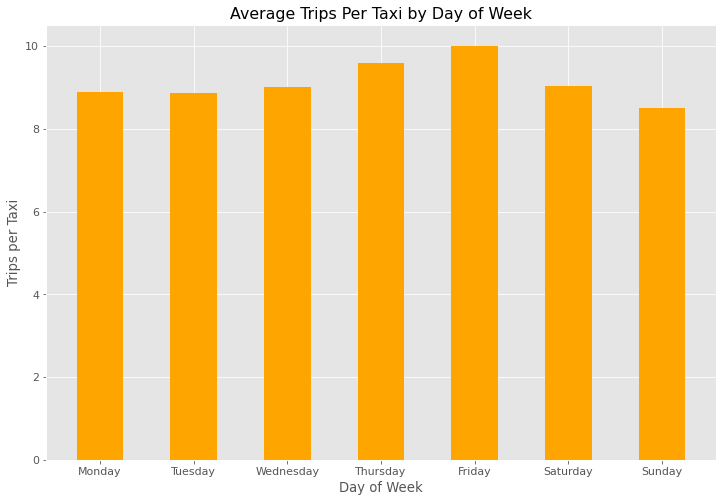

In [104]:

# distribution of trips within a day; by hour
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.set_xlabel('Trip Start Hour')
ax.set_ylabel('Trips per Taxi')
ax.set_title('Average Trips Per Taxi by Hour of Day')
ax.set_xticks( range(0,24,2))

ax.plot(df.groupby(['Trip Start Hour']).size()/(df.groupby(['Taxi ID','Trip Start Hour','Trip Date']).size().groupby(['Trip Start Hour']).size()))
plt.show()


# # distribution of trips based on day of the week    
dayofweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.set_xlabel('Day of Week')
ax.set_ylabel('Trips per Taxi')
ax.set_title('Average Trips Per Taxi by Day of Week')

data_dayofweek = df.groupby(['Trip Day of Week']).size()/df.groupby(['Taxi ID','Trip Day of Week','Trip Date']).size().groupby(['Trip Day of Week']).size()
ax.bar(range(7), data_dayofweek, width = 0.5, color = 'orange')
ax.set_xticks(range(7))
ax.set_xticklabels(dayofweek)
plt.show()

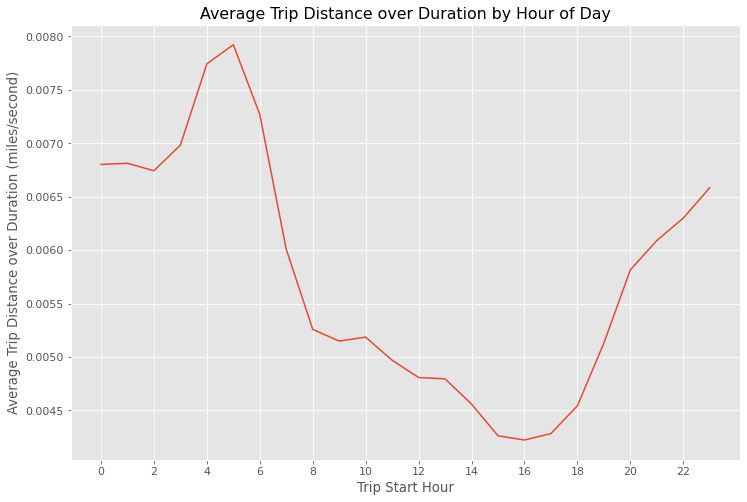

In [127]:
## distance over time
df['Trip Miles per Trip Second'] = df['Trip Miles'] / df['Trip Seconds']

# distribution of trips within a day; by hour
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.set_xlabel('Trip Start Hour')
ax.set_ylabel('Average Trip Distance over Duration (miles/second)')
ax.set_title('Average Trip Distance over Duration by Hour of Day')
ax.set_xticks( range(0,24,2))

ax.plot(df.groupby(['Trip Start Hour'])['Trip Miles per Trip Second'].mean())
plt.show()


### Spatial Analysis

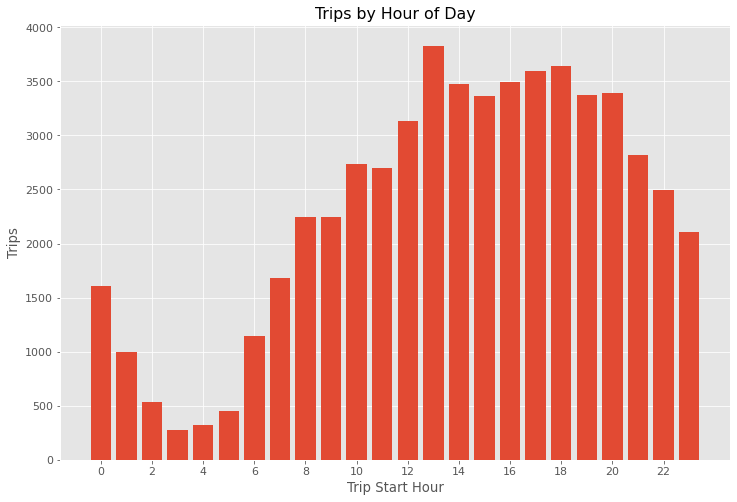

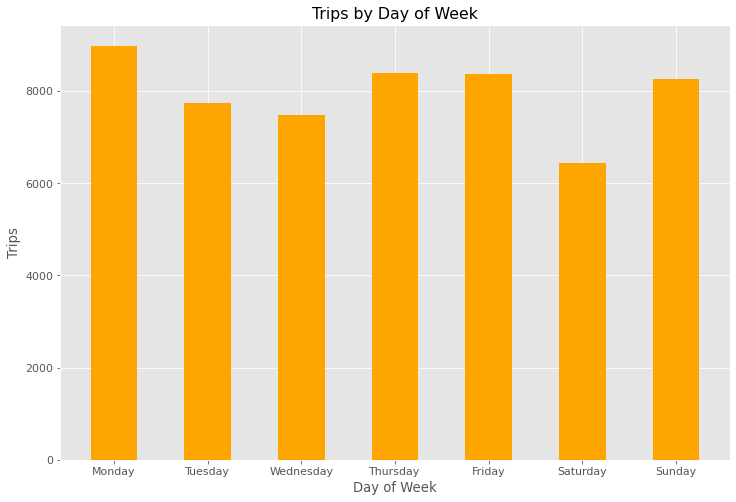

In [106]:
## into city
df_intocity = df[df['Pickup Centroid Location'].isnull() & df['Dropoff Centroid  Location'].notnull()]

plotHourAndDayTrends(df_intocity)

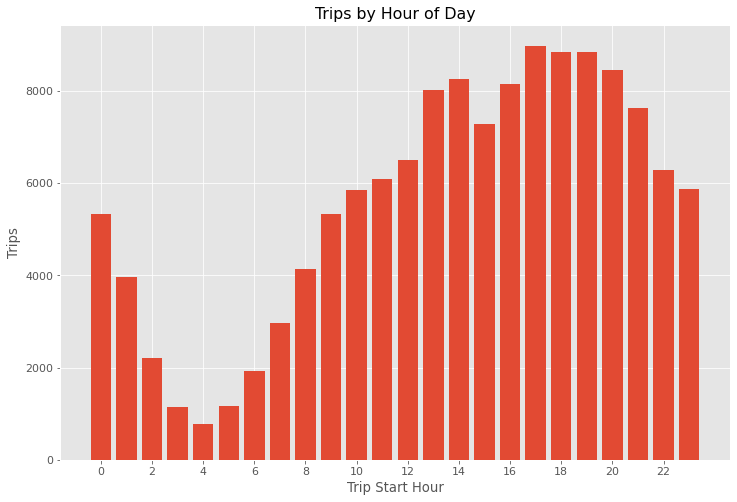

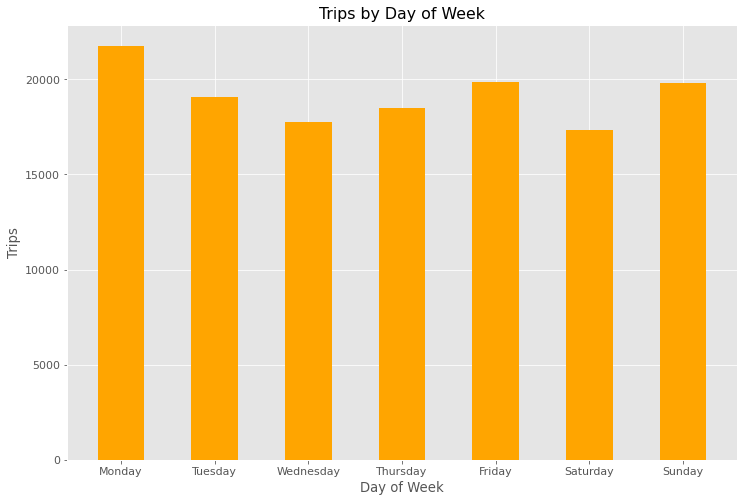

In [107]:
## trip out of city

df_outofcity = df[df['Pickup Centroid Location'].notnull() & df['Dropoff Centroid  Location'].isnull()]

plotHourAndDayTrends(df_outofcity)

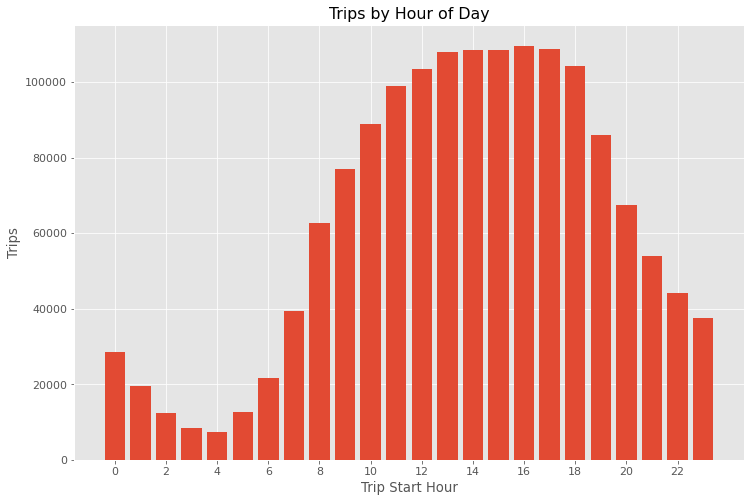

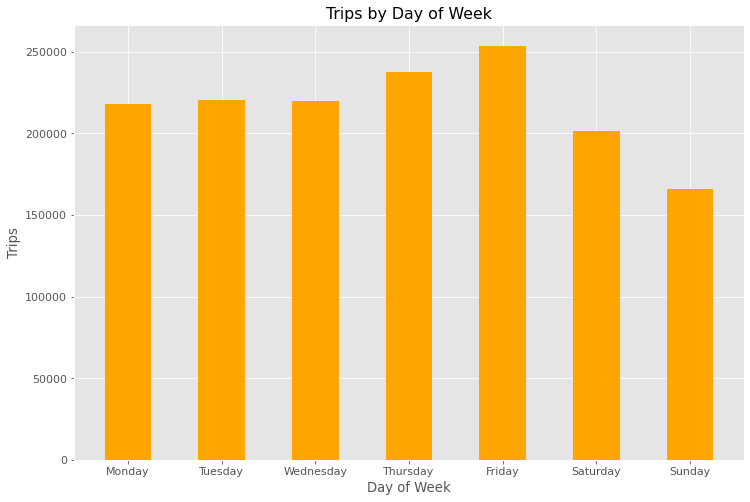

In [108]:
## trip within city

df_withincity = df[df['Pickup Centroid Location'].notnull() & df['Dropoff Centroid  Location'].notnull()]

plotHourAndDayTrends(df_withincity)

In [109]:
df['Pickup Centroid Location'].describe()

count                                 1651667
unique                                    355
top       POINT (-87.6333080367 41.899602111)
freq                                   249155
Name: Pickup Centroid Location, dtype: object

In [110]:
df['Dropoff Centroid  Location'].describe()

count                                 1573284
unique                                    485
top       POINT (-87.6333080367 41.899602111)
freq                                   214273
Name: Dropoff Centroid  Location, dtype: object

In [111]:
df.groupby(['Pickup Centroid Location']).size().sort_values(ascending = False)

Pickup Centroid Location
POINT (-87.6333080367 41.899602111)     249155
POINT (-87.913624596 41.9802643146)     170799
POINT (-87.6635175498 41.874005383)     107084
POINT (-87.6251921424 41.8788655841)    103679
POINT (-87.9030396611 41.9790708201)     85053
                                         ...  
POINT (-87.6500792603 41.7030819924)         1
POINT (-87.6517530558 41.6813147793)         1
POINT (-87.652031202 41.6958343746)          1
POINT (-87.701802904 42.0008748252)          1
POINT (-87.6545378676 41.980606166)          1
Length: 355, dtype: int64

In [112]:
df.groupby(['Dropoff Centroid  Location']).size().sort_values(ascending = False)

Dropoff Centroid  Location
POINT (-87.6333080367 41.899602111)     214273
POINT (-87.6635175498 41.874005383)      97549
POINT (-87.6559981815 41.9442266014)     85144
POINT (-87.6251921424 41.8788655841)     78706
POINT (-87.6494887289 41.9226862843)     65452
                                         ...  
POINT (-87.7452828446 41.7966403342)         1
POINT (-87.7509798603 41.9195645564)         1
POINT (-87.7516489576 41.9351139349)         1
POINT (-87.6295663156 41.7275849467)         1
POINT (-87.6616429039 41.9490605256)         1
Length: 485, dtype: int64

In [113]:
print("Lat min and max:", df['Pickup Centroid Latitude'].min() ,df['Pickup Centroid Latitude'].max() )
print("Long min and max:",df['Pickup Centroid Longitude'].min(),df['Pickup Centroid Longitude'].max() )
## dropoff
print("dropoff")
print("Lat min and max:", df['Dropoff Centroid Latitude'].min() ,df['Dropoff Centroid Latitude'].max() )
print("Long min and max:",df['Dropoff Centroid Longitude'].min(),df['Dropoff Centroid Longitude'].max() )

Lat min and max: 41.660136051 42.021223593
Long min and max: -87.913624596 -87.53490290100001
dropoff
Lat min and max: 41.660136051 42.021223593
Long min and max: -87.913624596 -87.53490290100001


In [114]:
import math

def LatLongToXY(LatLong_Coords):
    lat = LatLong_Coords[0]
    lon = LatLong_Coords[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

def getMapCoordinates(df_input, coordinateType):
    circle_size_logbase = 1.45
    min_size = 2
    
    coordinate_points = pd.DataFrame()
    
    if(coordinateType == 'Dropoff'):
        df_coordUnique = df_input[df_input['Dropoff Centroid  Location'].notnull()].groupby(['Dropoff Centroid Latitude','Dropoff Centroid Longitude']).size().reset_index()
        df_coordUnique = df_coordUnique.rename(columns = {0:'count'})
        df_coordUnique['Coordinate'] = list(zip(df_coordUnique['Dropoff Centroid Latitude'],df_coordUnique['Dropoff Centroid Longitude']))
    else: #Pickup
        df_coordUnique = df_input[df_input['Pickup Centroid Location'].notnull()].groupby(['Pickup Centroid Latitude','Pickup Centroid Longitude']).size().reset_index()
        df_coordUnique = df_coordUnique.rename(columns = {0:'count'})
        df_coordUnique['Coordinate'] = list(zip(df_coordUnique['Pickup Centroid Latitude'],df_coordUnique['Pickup Centroid Longitude']))
 
    coordinate_points['x_coord'] = df_coordUnique['Coordinate'].apply(lambda x: LatLongToXY(x)[0])
    coordinate_points['y_coord'] = df_coordUnique['Coordinate'].apply(lambda x: LatLongToXY(x)[1])
    coordinate_points['size'] = df_coordUnique['count'].apply(lambda x: math.log(x,circle_size_logbase) + min_size)
    
    return coordinate_points

In [115]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
tile_provider = get_provider(CARTODBPOSITRON)

Dropoff_points = getMapCoordinates(df,'Dropoff')
Pickup_points = getMapCoordinates(df,'Pickup')

def visualizePointsOnMap(CoordinatePointSets,colors, figure_range = [-9780000, -9745000, 5130000, 5160000]):
    p = figure(x_range=(figure_range[0], figure_range[1]), y_range=(figure_range[2], figure_range[3]),
               x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(tile_provider)
    
    for i in range(len(CoordinatePointSets)):
        p.circle(x = CoordinatePointSets[i]['x_coord'], 
                 y = CoordinatePointSets[i]['y_coord'], 
                 size = CoordinatePointSets[i]['size'],
                 color = colors[i], 
                 alpha = 0.3)

    output_notebook()
    show(p)
    return

visualizePointsOnMap([Dropoff_points, Pickup_points],['blue','red'])

Loading BokehJS ...

In [116]:
## Dropoff pattern over the day
fig_range = [-9785000, -9745000, 5110000, 5165000]

# night [24,6)
df_night = df[ (df['Trip Start Hour'] < 6)]
Dropoff_night = getMapCoordinates(df_night,'Dropoff')
visualizePointsOnMap([Dropoff_night],['blue'],fig_range)

# morning rush hour [6,12)
df_morning = df[(df['Trip Start Hour'] >= 6) & (df['Trip Start Hour'] < 12)]
Dropoff_morning = getMapCoordinates(df_morning,'Dropoff')
visualizePointsOnMap([Dropoff_morning],['blue'],fig_range)

# noon  [12,18)
df_noon = df[(df['Trip Start Hour'] >= 12) & (df['Trip Start Hour'] < 18)]
Dropoff_noon = getMapCoordinates(df_noon,'Dropoff')
visualizePointsOnMap([Dropoff_noon],['blue'],fig_range)

# evening rush hour [18,24)
df_evening = df[(df['Trip Start Hour'] >= 18) & (df['Trip Start Hour'] < 24)]
Dropoff_evening = getMapCoordinates(df_evening,'Dropoff')
visualizePointsOnMap([Dropoff_evening],['blue'],fig_range)



Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [117]:
## Pickup pattern over the day
fig_range = [-9785000, -9745000, 5110000, 5165000]

# night [24,6)
df_night = df[ (df['Trip Start Hour'] < 6)]
Pickup_night = getMapCoordinates(df_night,'Pickup')
visualizePointsOnMap([Pickup_night],['red'],fig_range)

# morning rush hour [6,12)
df_morning = df[(df['Trip Start Hour'] >= 6) & (df['Trip Start Hour'] < 12)]
Pickup_morning = getMapCoordinates(df_morning,'Pickup')
visualizePointsOnMap([Pickup_morning],['red'],fig_range)

# noon  [12,18)
df_noon = df[(df['Trip Start Hour'] >= 12) & (df['Trip Start Hour'] < 18)]
Pickup_noon = getMapCoordinates(df_noon,'Pickup')
visualizePointsOnMap([Pickup_noon],['red'],fig_range)

# evening rush hour [18,24)
df_evening = df[(df['Trip Start Hour'] >= 18) & (df['Trip Start Hour'] < 24)]
Pickup_evening = getMapCoordinates(df_evening,'Pickup')
visualizePointsOnMap([Pickup_evening],['red'],fig_range)



Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [118]:
## Pickup and dropoff pattern over the day
fig_range = [-9785000, -9745000, 5110000, 5165000]

# night [24,6)
df_night = df[ (df['Trip Start Hour'] < 6)]
Dropoff_night = getMapCoordinates(df_night,'Dropoff')
Pickup_night = getMapCoordinates(df_night,'Pickup')
visualizePointsOnMap([Dropoff_night,Pickup_night],['blue','red'], fig_range)

# morning rush hour [6,12)
df_morning = df[(df['Trip Start Hour'] >= 6) & (df['Trip Start Hour'] < 12)]
Dropoff_morning = getMapCoordinates(df_morning,'Dropoff')
Pickup_morning = getMapCoordinates(df_morning,'Pickup')
visualizePointsOnMap([Dropoff_morning,Pickup_morning],['blue','red'], fig_range)

# noon  [12,18)
df_noon = df[(df['Trip Start Hour'] >= 12) & (df['Trip Start Hour'] < 18)]
Dropoff_noon = getMapCoordinates(df_noon,'Dropoff')
Pickup_noon = getMapCoordinates(df_noon,'Pickup')
visualizePointsOnMap([Dropoff_noon,Pickup_noon],['blue','red'], fig_range)

# evening rush hour [18,24)
df_evening = df[(df['Trip Start Hour'] >= 18) & (df['Trip Start Hour'] < 24)]
Dropoff_evening = getMapCoordinates(df_evening,'Dropoff')
Pickup_evening = getMapCoordinates(df_evening,'Pickup')
visualizePointsOnMap([Dropoff_evening,Pickup_evening],['blue','red'], fig_range)



Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [119]:
def getTripDF(df_input):
    df_trips = df_input[df_input['Dropoff Centroid  Location'].notnull() & df_input['Pickup Centroid Location'].notnull()].groupby(['Dropoff Centroid Latitude','Dropoff Centroid Longitude','Pickup Centroid Latitude','Pickup Centroid Longitude']).size().reset_index()
    df_trips = df_trips.rename(columns = {0:'count'})
    df_trips['count'] = df_trips['count'] 

    df_trips['Pickup Coordinate'] = list(zip(df_trips['Pickup Centroid Latitude'],df_trips['Pickup Centroid Longitude']))
    df_trips['Dropoff Coordinate'] = list(zip(df_trips['Dropoff Centroid Latitude'],df_trips['Dropoff Centroid Longitude']))

    df_trips['pickup_x'] = df_trips['Pickup Coordinate'].apply(lambda x: LatLongToXY(x)[0])
    df_trips['pickup_y'] = df_trips['Pickup Coordinate'].apply(lambda x: LatLongToXY(x)[1])
    df_trips['dropoff_x'] = df_trips['Dropoff Coordinate'].apply(lambda x: LatLongToXY(x)[0])
    df_trips['dropoff_y'] = df_trips['Dropoff Coordinate'].apply(lambda x: LatLongToXY(x)[1])
    
    segment_size_logbase = 10
    min_size = 0.05
    max_count = df_trips['count'].max()
    df_trips['size'] = df_trips['count'].apply(lambda x: x/max_count*0.45 + min_size)
    #df_trips['size'] = df_trips['count'].apply(lambda x: math.log(x,segment_size_logbase) + min_size)

    return df_trips

df_all = getTripDF(df)

In [120]:

def visualizeTravelSegmentsOnMap(SegmentsSets,colors,figure_range = [-9780000, -9745000, 5130000, 5160000]):
    p = figure(x_range=(figure_range[0], figure_range[1]), y_range=(figure_range[2], figure_range[3]),
               x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(tile_provider)
    
    for i in range(len(SegmentsSets)):
        p.segment(x0=SegmentsSets[i]['pickup_x'], 
                  y0=SegmentsSets[i]['pickup_y'],
                  x1=SegmentsSets[i]['dropoff_x'],
                  y1=SegmentsSets[i]['dropoff_y'],
                  color= colors[i], 
                  line_width= 2, #SegmentsSets[i]['size'], 
                  alpha = SegmentsSets[i]['size'])

    output_notebook()
    show(p)
    
visualizeTravelSegmentsOnMap([df_all],['teal'],[-9785000, -9745000, 5110000, 5165000])

Loading BokehJS ...

In [121]:
df_all.sort_values(['count'],ascending = False).head(10)
df_top_PD = df_all.sort_values(['count'],ascending = False).head(100).copy()
visualizeTravelSegmentsOnMap([df_top_PD],['red'], fig_range)

Loading BokehJS ...

In [122]:
## Travel pattern over the day
fig_range = [-9785000, -9745000, 5110000, 5165000]

# night [24,6)
df_night = df[ (df['Trip Start Hour'] < 6)]
trips_night = getTripDF(df_night)
visualizeTravelSegmentsOnMap([trips_night],['teal'], fig_range)

# morning rush hour [6,12)
df_morning = df[(df['Trip Start Hour'] >= 6) & (df['Trip Start Hour'] < 12)]
trips_morning = getTripDF(df_morning)
visualizeTravelSegmentsOnMap([trips_morning],['teal'], fig_range)

# noon  [12,18)
df_noon = df[(df['Trip Start Hour'] >= 12) & (df['Trip Start Hour'] < 18)]
trips_noon = getTripDF(df_noon)
visualizeTravelSegmentsOnMap([trips_noon],['teal'], fig_range)

# evening rush hour [18,24)
df_evening = df[(df['Trip Start Hour'] >= 18) & (df['Trip Start Hour'] < 24)]
trips_evening = getTripDF(df_evening)
visualizeTravelSegmentsOnMap([trips_evening],['teal'], fig_range)


#visualizeTravelSegmentsOnMap([trips_evening,trips_noon,trips_morning,trips_night],['blue','red','orange','teal'], fig_range)


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...